# Ecuación de Duffing:
## Resolución numérica

El oscilador de Duffing consiste en un oscilador forzado en el que la fuerza de restitución se encuentra dada por: $F_{rest}(x)=-\alpha x-\beta x^3$. Con esto, el oscilador se encuentra descrito por la ecuación:

$$\ddot{x}+\delta\dot{x}+\alpha x+\beta x^3=\gamma cos(\omega t).$$

# 1. ¿Qué significa físicamente?

Para valores de $\beta >0$, el sistema se ve como un resorte que no sigue la ley de Hooke y puede utilizarse para modelar resortes más *reales*, pues presenta un ciclo de histéresis de respuesta a frecuencias.

Para $\beta<0$, el sistema describe a una masa en un potencial de doble pozo y una representación física es el forzamiento periódico de una barra metálica entre dos imanes.
<img src="images/img3.gif">
[1] http://scholarpedia.org/article/File:Duffing-MagnetelasticBeam.gif

## 2. Soluciones numéricas con Runge-Kutta 4, *odeint* y series de Taylor

Es un sistema dinámico relativamente sencillo que presenta caos.

Solucionamos el sistema con 3 métodos distintos:
- `odeint` incluido en la librería `scipy` de Python.
- Runge-Kutta de 4to orden desarrollado en clase.
- Series de Taylor truncadas con diferenciación automática.

Hacemos un pequeño análisis de rapidez y precisión para cada método, analizando sus ventajas y sus desventajas para distintos sistemas.

In [1]:
from taylorSeries import *
import numpy as np
from random import *
import timeit
import scipy.integrate as spi
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def arg_rk4(funcion,x0,tlist,args=0,h=0.1):
    """
    Funcion de Integracion por el Metodo de Runge-Kutta a 4o orden. Sus argumentos son: la funcion de la ecuacion diferencial,
    el valor de la funcion al tiempo inicial x0,una lista con el tiempo inicial y el final tlist=[ti,tf] y 
    el paso de integracion como argumento opcional. 
    Puede tener una lista de parametros opcionales args que se pasan a la funcion de la ecuacion diferencial.
    Regresa los tiempos y sus respectivos valores de la funcion como una tupla de arrays t,x. 
    Cabe notar que la funcion, el jacobiano y x0 pueden tomar valores vectoriales, los cuales se representan por arrays.
    Tambien, la funcion debe tener ordenados los parámetros de la forma g(t,x).
    """
    if (tlist[1]-tlist[0])<10.0*h:   #cambia el valor de h para garantizar que se hagan almenos 10 iteraciones
        h=(tlist[1]-tlist[0])*0.1
    tiempos=np.arange(tlist[0],tlist[1],h) #regresa un array
    x = np.zeros((len(tiempos),len(x0)))#regresa otro array del ancho de la dimension de x0 y el largo del array de tiempos)
    x[0,:] = x0 #x[tiempo,coordenada],:==todas las coordenadas
    if args == 0:  #no hay argumentos opcionales dados    
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(x[i,:],tiempos[i])
            k2=funcion(x[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3=funcion(x[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4=funcion(x[i,:]+h*k3,tiempos[i]+h)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    else:
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(x[i,:],tiempos[i],*args)
            k2=funcion(x[i,:]+0.5*h*k1,tiempos[i]+0.5*h,*args)
            k3=funcion(x[i,:]+0.5*h*k2,tiempos[i]+0.5*h,*args)
            k4=funcion(x[i,:]+h*k3,tiempos[i]+h,*args)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    return tiempos,x 
#regresa una tupla, que la hace inmutable a diferencia de una lista y que, a diferencia de un array, 
#cada entrada puede ser de distinto tipo (heterogéneas)

Para obtener la ecuación de movimiento, hacemos el cambio de variable $\begin{cases}x_1=x(t) \\x_2=\dot{x}(t) \end{cases} \Rightarrow \dot{x_2}=\ddot{x}(t)$. Entonces, se tiene que $\begin{cases}\dot{x_1}=x_2 \\ \dot{x_2}=\gamma cos(\omega t)-\delta x_2-\alpha x_1-\beta x_1^3  \end{cases}$

Por tanto, el sistema se puede escribir como $\dot{\vec{x}}=\vec{g}(t,\vec{x})$, con $\vec{x}=(x_1,x_2)$ y $\vec{g}=(x_2,\gamma cos(\omega t)-\delta x_2-\alpha x_1-\beta x_1^3)$.

In [3]:
def ec_mov(x,t,alpha=5.,beta=1.,gamma=0.5,delta=0.2,omega=1.5): #x=(x1,x2)=(x,dx)
    dx1=x[1]
    dx2=gamma*np.cos(omega*t)-delta*x[1]-alpha*x[0]-beta*x[0]**3
    return np.array([dx1,dx2]) #regresa un array  

Tomaremos los parámetros $\alpha=-1, \beta=1,\gamma=0.3, \delta=0.2$ y consideramos $\omega$ cercano a 1.

Barreremos el parámetro de la frecuencia para ver qué pasa con la dinámica del sistema.

<img src="images/w1.png">
<img src="images/w2.png">

<img src="images/w3.png">
<img src="images/w4.png">

<img src="images/w5.png">
<img src="images/w6.png">

<img src="images/w7.png">
<img src="images/w8.png">

<img src="images/w9.png">
<img src="images/w10.png">

Observamos que para $\omega \approx 0.925$ y $\omega \approx 1.025$ tenemos órbitas cerradas (bueno, casi), mientras que para otros valores de la frecuencia el régimen es caótico.

Observamos que las tres soluciones empiezan igual pero que las trayectorias se separan relativamente rápido. `odeint` fue el más rápido de todos pero con precisión rondando $1e-7$.

Runge-Kutta fue 10 veces más lento que `odeint` y además tuvo mala precisión de cerca de $1e-3$, aunque esto no fue evidente sino hasta tiempos avanzados.

El método de Taylor fue mucho más lento (se tardó en promedio 100 veces más que RK4) pero con una precisión de $1e-20$, que se hace evidente en los desvíos tempranos de las trayectorias.

Wall time: 247 ms
Wall time: 16 ms
Wall time: 10.8 s


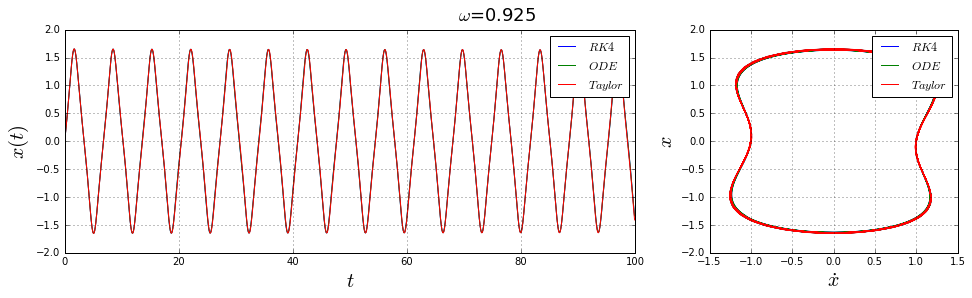

Wall time: 245 ms
Wall time: 13 ms
Wall time: 11.1 s


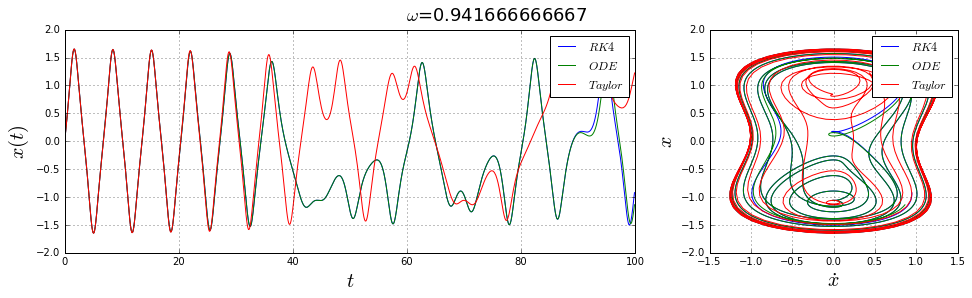

Wall time: 298 ms
Wall time: 17 ms
Wall time: 11.1 s


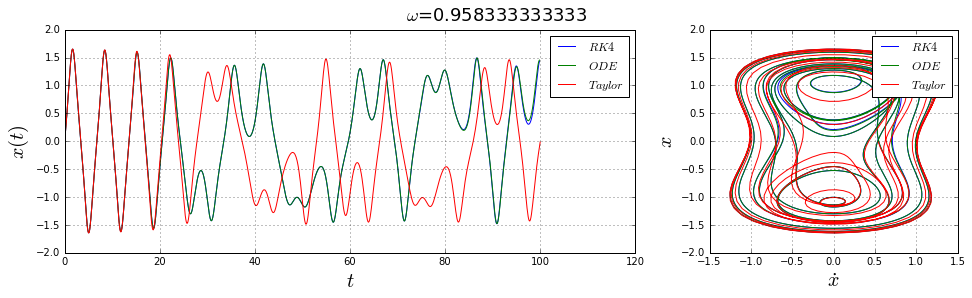

Wall time: 296 ms
Wall time: 16 ms
Wall time: 10.5 s


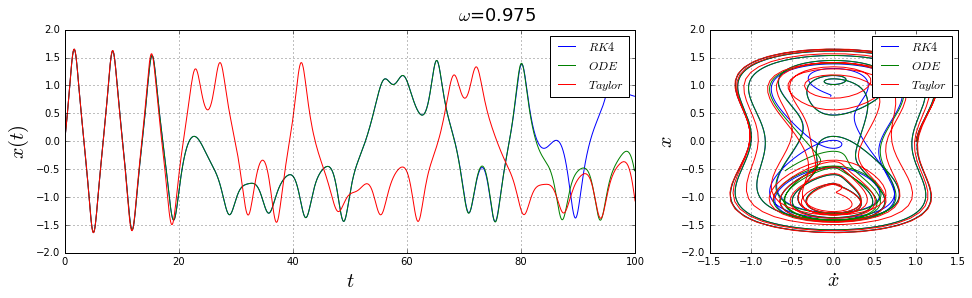

Wall time: 298 ms
Wall time: 15 ms
Wall time: 10.1 s


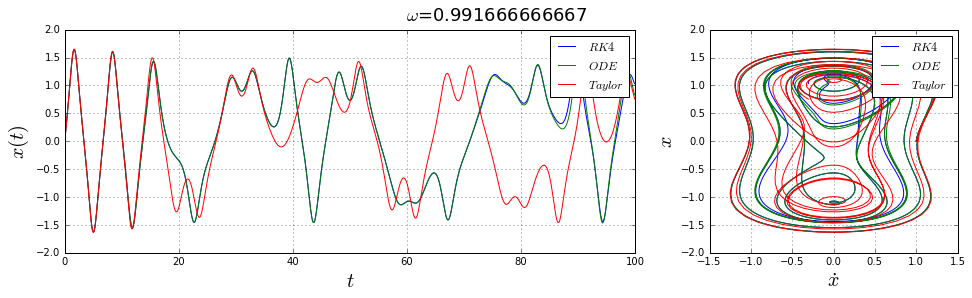

Wall time: 338 ms
Wall time: 16 ms
Wall time: 10.8 s


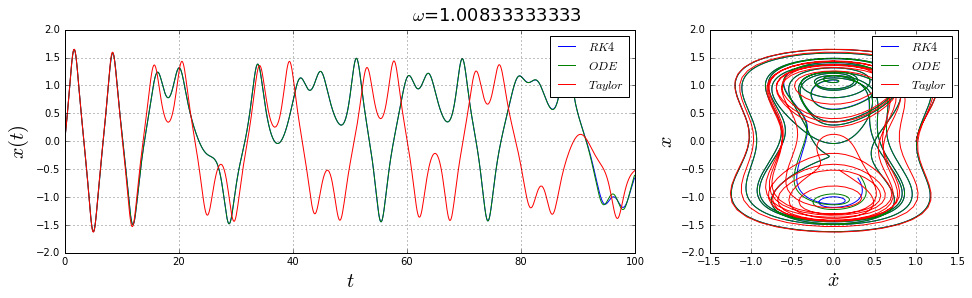

Wall time: 302 ms
Wall time: 17 ms
Wall time: 11.3 s


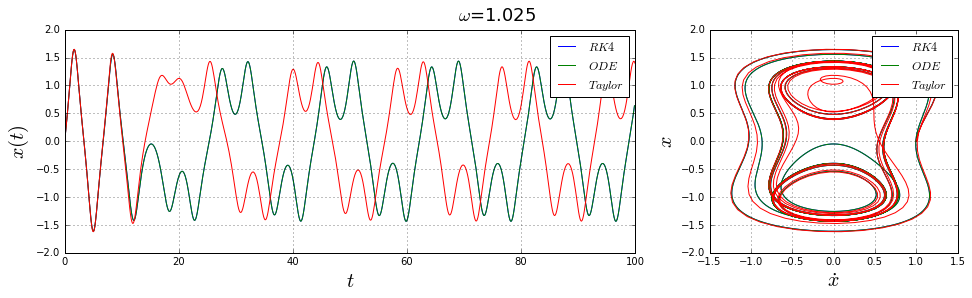

Wall time: 310 ms
Wall time: 15 ms
Wall time: 10.4 s


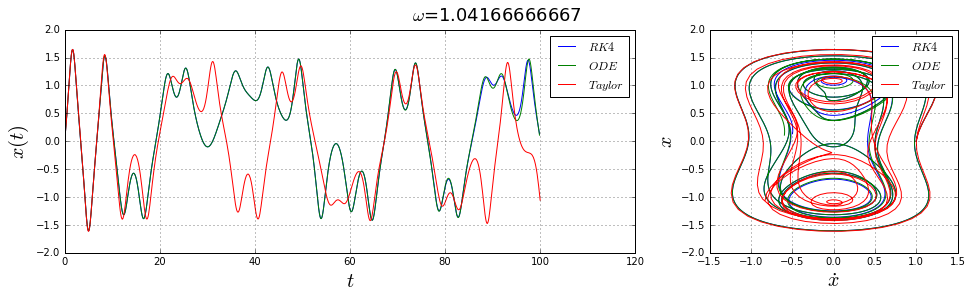

Wall time: 317 ms
Wall time: 16 ms
Wall time: 10.6 s


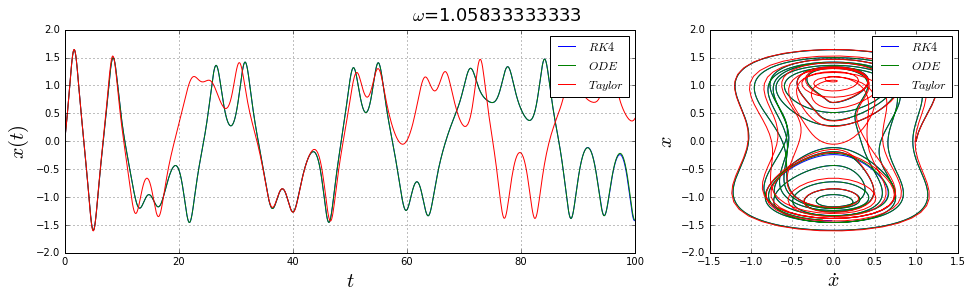

Wall time: 310 ms
Wall time: 16 ms
Wall time: 10.7 s


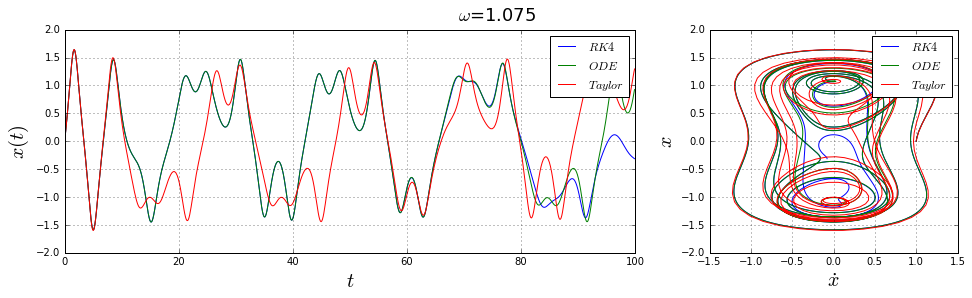

In [11]:
paso=0.01
x0=[0,1]
t0,tf=0.,99.9
tiempos=np.arange(t0,tf,paso)
lista_omegas=np.linspace(0.925,1.075,10).tolist()

for i,omega in enumerate(lista_omegas):
    args=(-1.,1.,0.3,0.2,omega) #explota con alpha=1, beta=-1
    %time t,sol_rk4=arg_rk4(ec_mov,x0,[0,tf],args,h=paso)
    %time sol_ode=spi.odeint(ec_mov,x0,tiempos,args=args)
    %time tt,xt,yt=intDuffing(x0[0],x0[1],t0,tf,funcDuffing,omega,eps=1e-15)
    
    fig=plt.figure(figsize=(16,4))
    fig.suptitle('$\omega$={}'.format(omega),fontsize=18)
    gs=gridspec.GridSpec(1, 3,wspace=0.3)
    ax1 = plt.subplot(gs[0, :-1])
    ax2 = plt.subplot(gs[0, -1])
    
    ax1.plot(t,sol_rk4[:,0],label="$RK4$")
    ax1.plot(t,sol_ode[:,0],label="$ODE$")
    ax1.plot(tt,xt,'r',label="$Taylor$")
    ax1.set_ylabel('$x(t)$',fontsize=20)
    ax1.set_xlabel('$t$',fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2.plot(sol_rk4[:,1],sol_rk4[:,0],label="$RK4$")
    ax2.plot(sol_ode[:,1],sol_ode[:,0],label="$ODE$")
    ax2.plot(yt,xt,'r',label="$Taylor$")
    ax2.set_ylabel('$x$',fontsize=20)
    ax2.set_xlabel('$\dot{x}$',fontsize=20)
    ax2.legend()
    ax2.grid()
    plt.show()

Ahora haremos un barrido de otro parámetro $\gamma$ para ver los regímenes caóticos del sistema, tomando el resto de los argumentos constantes ($\alpha=-1, \beta=1, \delta=0.2$ y $\omega=1$, con $\gamma$ cercano a 3).

<img src="images/g1.png">
<img src="images/g2.png">

<img src="images/g3.png">
<img src="images/g5.png">

<img src="images/g7.png">
<img src="images/g8.png">

<img src="images/g9.png">
<img src="images/g10.png">

Observamos que para la región $\gamma \in (0.3,0.6) $ el comportamiento del sistema el altamente caótico, mientras que para $\gamma \approx 0.25$ y $\gamma \approx 0.65$ se tienen órbitas periódicas cerradas.

Wall time: 291 ms
Wall time: 14 ms


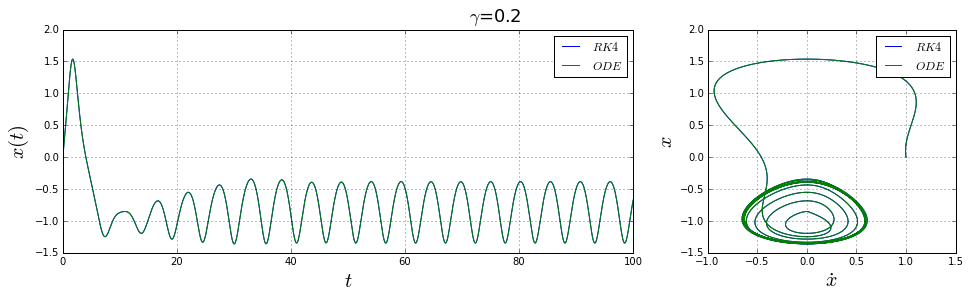

Wall time: 336 ms
Wall time: 15 ms


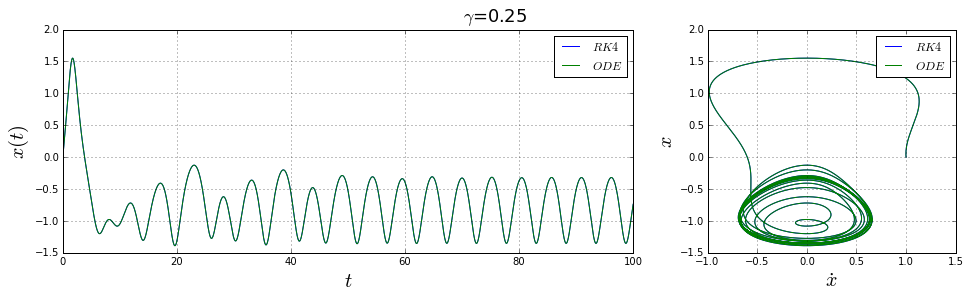

Wall time: 341 ms
Wall time: 16 ms


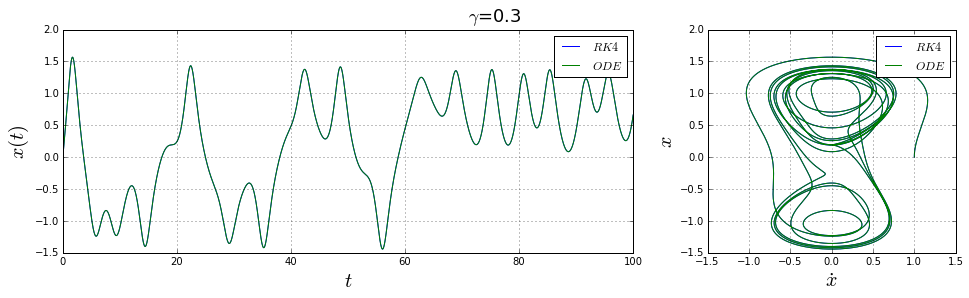

Wall time: 296 ms
Wall time: 15 ms


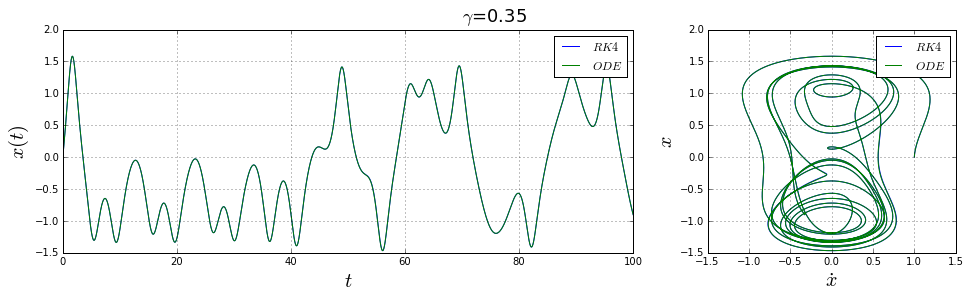

Wall time: 292 ms
Wall time: 13 ms


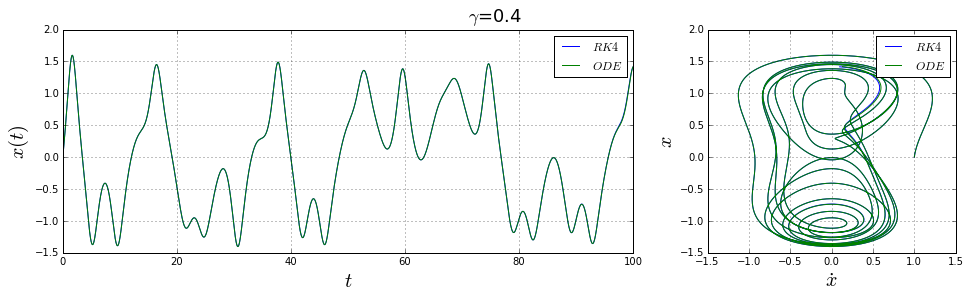

Wall time: 329 ms
Wall time: 13 ms


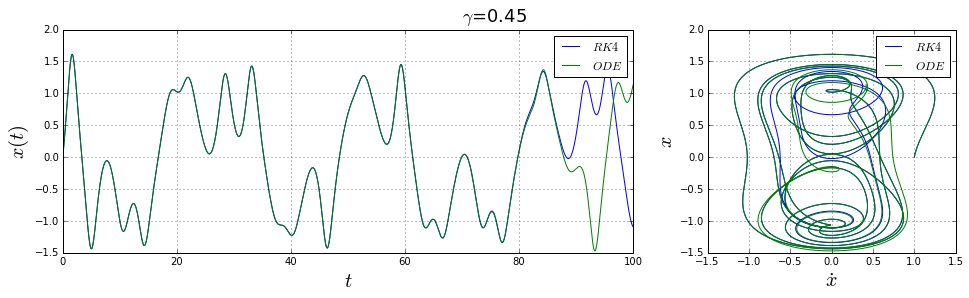

Wall time: 319 ms
Wall time: 15 ms


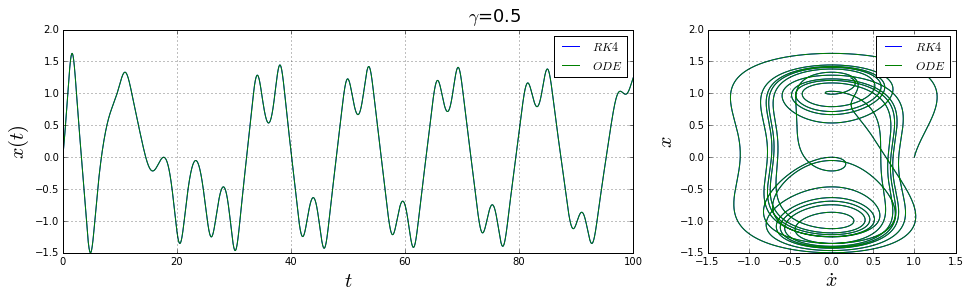

Wall time: 301 ms
Wall time: 15 ms


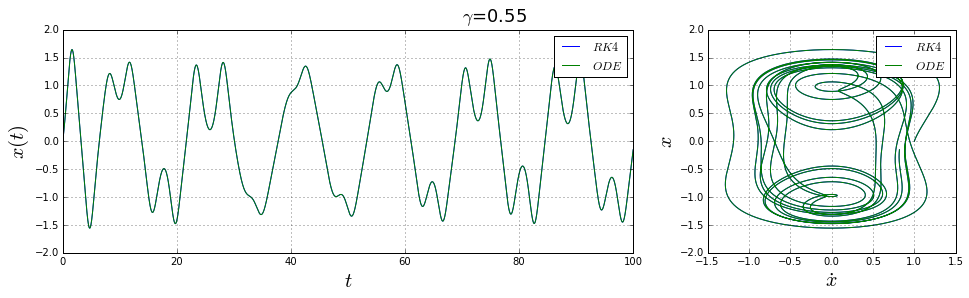

Wall time: 286 ms
Wall time: 15 ms


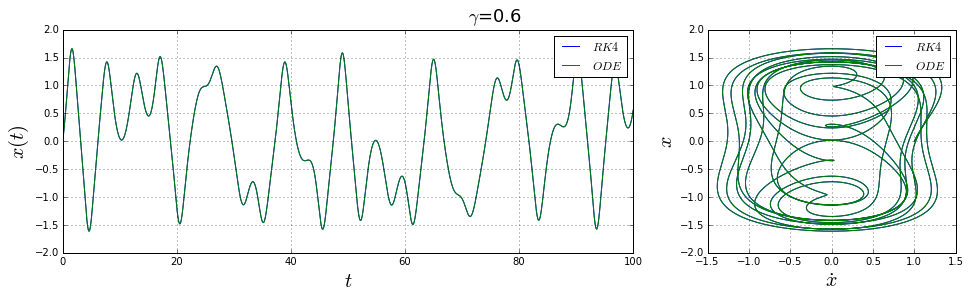

Wall time: 297 ms
Wall time: 18 ms


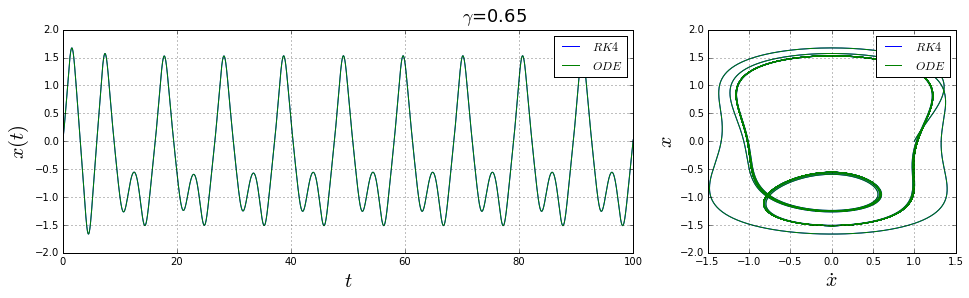

In [102]:
paso=0.01
x0=[0,1]
tf=100
tiempos=np.arange(0,100,paso)
lista_gammas=np.linspace(0.20,0.65,10).tolist()

for i,gamma in enumerate(lista_gammas):
    args=(-1.,1.,gamma,0.3,1.2) #explota con alpha=1, beta=-1
    %time t,sol_rk4=arg_rk4(ec_mov,x0,[0,tf],args,h=paso)
    %time sol_ode=spi.odeint(ec_mov,x0,tiempos,args=args)
    
    fig=plt.figure(figsize=(16,4))
    fig.suptitle('$\gamma$={}'.format(gamma),fontsize=18)
    gs=gridspec.GridSpec(1, 3,wspace=0.3)
    ax1 = plt.subplot(gs[0, :-1])
    ax2 = plt.subplot(gs[0, -1])
    
    ax1.plot(t,sol_rk4[:,0],label="$RK4$")
    ax1.plot(t,sol_ode[:,0],label="$ODE$")
    ax1.set_ylabel('$x(t)$',fontsize=20)
    ax1.set_xlabel('$t$',fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2.plot(sol_rk4[:,1],sol_rk4[:,0],label="$RK4$")
    ax2.plot(sol_ode[:,1],sol_ode[:,0],label="$ODE$")
    ax2.set_ylabel('$x$',fontsize=20)
    ax2.set_xlabel('$\dot{x}$',fontsize=20)
    ax2.legend()
    ax2.grid()
    plt.show()

# 3. Mapa de recurrencia para órbitas periódicas

Ahora construiremos un mapeo de Poincaré para una trayectoria específica. Lo que haremos es fijarnos en un punto de la trayectoria después de que transcurra un periodo del forzamiento, i.e., $t=2\pi \omega n$.

In [ ]:
def Mapeo_Poincare(ec_mov,xini,tlist,alpha=5.,beta=1.,gamma=0.5,delta=0.2,omega=1.5): #x=(x1,x2)=(x,dx), tlist=[t0,tf]
    